In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

C:\Users\Ashish\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = './Data/'
preprocess = False

filename_read = os.path.join(path,'mpg.csv')
df = pd.read_csv(filename_read, na_values=['NA','?'])

In [3]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
  


In [4]:
# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')

x,y = to_xy(df, 'mpg')

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=12)

model = Sequential()
model.add(Dense(20, 
                input_dim=x.shape[1], 
                activation='relu'))
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',
              optimizer='adam')
monitor = EarlyStopping(monitor='val_loss',
                        min_delta=1e-3, 
                        patience=5, 
                        verbose=1, 
                        mode='auto')
checkpointer = ModelCheckpoint(filepath="best_wt.hdf5", 
                               verbose=0, 
                               save_best_only=True) # save best model
model.fit(x_train,y_train,
          validation_data=(x_test,y_test),
          callbacks=[monitor,checkpointer],
          verbose=0,
          epochs=1000)
model.load_weights('best_wt.hdf5')

Epoch 00040: early stopping


In [9]:
# predict and measure RMSE

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("score:{}".format(score))

score:4.218292713165283


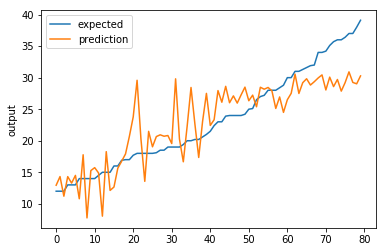

In [15]:
# Plot the chart

%matplotlib  inline

import matplotlib.pyplot as plt
chart_regression(pred.flatten(),y_test)

In [ ]:
# the expected and precit lines should be close.
# the chart is most accurate on lower MPG

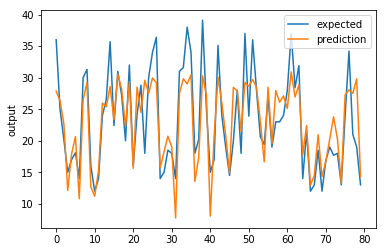

In [16]:
chart_regression(pred.flatten(),y_test,sort=False)